In [1]:
%%bash
pip install --no-cache-dir --upgrade pip
pip install --no-cache-dir -r requirements.txt
pip install ipympl
pip install ipython jupyter matplotlib

In [2]:
%matplotlib inline
%matplotlib widget
import numpy as np                                
import math

import scipy.sparse as sparse
from scipy.sparse import csc_matrix, linalg, csr_matrix
from scipy.sparse import spdiags, eye
from scipy.sparse.linalg import spsolve


import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

In [3]:
import os
import numpy as np

from meshtest import meshtest

def readquad(ext=None, path="."):
    """
    Read quadrilateral FEM mesh from files in a given directory.

    Parameters
    ----------
    ext : str or None
        File extension (e.g. 'alt', 'sect')
    path : str
        Directory containing mesh files

    Returns
    -------
    nodes, xnod, ynod, bnod, nele, nno
    """

    ex = ""
    if ext is not None:
        ex = f".{ext}"

    def fname(base):
        return os.path.join(path, f"{base}{ex}")

    xnod = np.loadtxt(fname("xcoor"))
    ynod = np.loadtxt(fname("ycoor"))
    bnod = np.loadtxt(fname("bnode"), dtype=int)

    nno = xnod.size

    if ynod.size != nno or bnod.size != nno:
        raise ValueError("Global coordinates erroneous ...")

    if not np.all((bnod == 0) | (bnod == 1)):
        raise ValueError("Wrong boundary indicator ...")

    nodes_flat = np.loadtxt(fname("nodes"), dtype=int)

    if nodes_flat.size % 4 != 0:
        raise ValueError("Wrong number of numbers in nodes ...")

    nele = nodes_flat.size // 4
    nodes = nodes_flat.reshape((nele, 4))

    # MATLAB → Python indexing
    nodes -= 1

    nodes = meshtest(nodes, xnod, ynod)

    return nodes, xnod, ynod, bnod, nele, nno


In [4]:

def plotmesh(xnod, ynod, nodes):
    """
    Plot an unstructured 2D quadrilateral mesh.

    Parameters
    ----------
    xnod, ynod : (nno,) ndarray
        Node coordinates
    nodes : (nele, 4) ndarray of int
        Element connectivity (0-based)
    """

    # Flatten connectivity
    nn = nodes.ravel()

    # Coordinates corresponding to nodes
    xx = xnod[nn]
    yy = ynod[nn]

    # Reshape back to element-wise arrays
    xplot = xx.reshape(nodes.shape)
    yplot = yy.reshape(nodes.shape)

    plt.clf()
    plt.gca().set_aspect('equal', adjustable='box')

    # Matplotlib fill: each row is one polygon
    plt.fill(xplot.T, yplot.T, facecolor='white', edgecolor='black')

    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Quadrilateral FEM Mesh")
    plt.show()


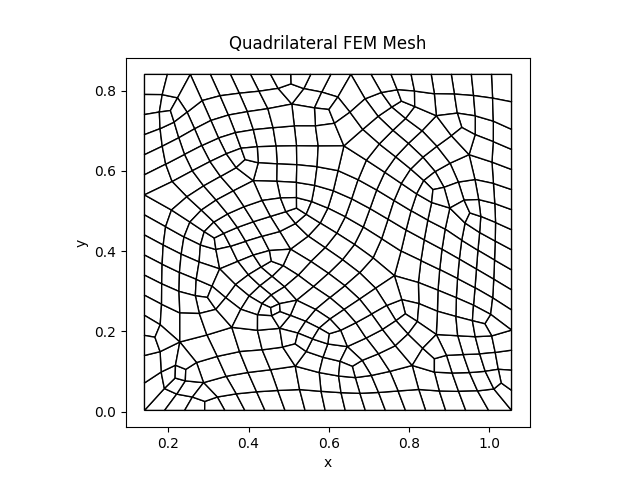

In [5]:
nodes, xnodes, ynodes, bnod, nele, nno = readquad(ext="alt", path="files")

plotmesh(xnodes, ynodes, nodes)

## Model Problem: Poisson Equation:

Poisson Equation with variable conductivity \(k\):

&emsp;&emsp; 
$
\nabla \cdot (\, k \, \nabla u \,) = f \quad \text{in } \Omega,
$

and Dirichlet boundary condition:

&emsp;&emsp; 
$
u = g \quad \text{on } \partial \Omega.
$


In [6]:
import numpy as np

# Scalar coefficient
def K(x, y):
    return 1.0

# Source term to match u = sin(x)
def FLoad(x, y):
    return np.sin(x)

# Dirichlet boundary (exact solution)
def g(x, y):
    return np.sin(x)


## Basis Functions For A Quad Element:

| Shape function | $L_i^{(1)}(\xi)$ | $L_j^{(1)}(\eta)$ | Formula |
|----------------|------------|------------|---------|
| $\phi_1(\xi,\eta) = L_0(\xi).L_0(\eta)$ | $1-\xi$ | $1-\eta$ | $(1-\xi)(1-\eta)$ |
| $\phi_2(\xi,\eta) = L_1(\xi).L_0(\eta)$ | $\xi$    | $1-\eta$ | $\xi(1-\eta)$ |
| $\phi_3(\xi,\eta) = L_1(\xi).L_1(\eta)$ | $\xi$    | $\eta$   | $\xi \eta$ |
| $\phi_4(\xi,\eta) = L_0(\xi).L_1(\eta)$ | $1-\xi$ | $\eta$   | $(1-\xi)\eta$ |


Each $\phi_i$ satisfies $\phi_i(\xi_j)=\delta_{ij}$

In [7]:
# Basis functions
def PHI_Q_1(e,n): return (1-e)*(1-n)
def PHI_Q_2(e,n): return e*(1-n)
def PHI_Q_3(e,n): return e*n
def PHI_Q_4(e,n): return (1-e)*n

## Mapping to Physical Coordinates for Each Quad

We know the grid points $(x_i, y_i)$.  The above shape functions can also be used to interpolate between them: 

Given the nodal points for each Quad:

$ 
\mathbf{x}=
\begin{bmatrix}
    x_1 & x_2 & x_3 & x_4
\end{bmatrix}^T
$

$
\mathbf{y}=
\begin{bmatrix}
    y_1 & y_2 & y_3 & y_4
\end{bmatrix}^T
$

And the shape function vector $\boldsymbol{\Phi}(\xi,\eta)$ ( notation: $\Phi$ wihout index): 

$
\boldsymbol{\Phi}(\xi,\eta)=
\begin{bmatrix}
\phi_1(\xi,\eta) &
\phi_2(\xi,\eta) &
\phi_3(\xi,\eta) &
\phi_4(\xi,\eta)
\end{bmatrix}
$



We can use the following mapping from Reference  $(\xi, \eta)$  cooridnates to Physical (x,y):

$
x(\xi, \eta) = \sum_{i=1}^{4} x_i \, \phi_i(\xi, \eta) = \mathbf{x}^T \boldsymbol{\Phi}(\xi,\eta)
$


$
y(\xi, \eta) = \sum_{i=1}^{4} y_i \, \phi_i(\xi, \eta) = \mathbf{y}^T \boldsymbol{\Phi}(\xi,\eta)
$




There are two more simple vectors we can define, which are just the gradients of the shape functions over the Quad in $(\xi,\eta)$.  <br>
These will be usefull when calculating the Jacobian later (see the table in Appendix for how the values are calculated):

$\frac{\partial \boldsymbol{\Phi}}{\partial \xi} =
\begin{bmatrix}
\frac{\partial \phi_1}{\partial \xi} &
\frac{\partial \phi_2}{\partial \xi} &
\frac{\partial \phi_3}{\partial \xi} &
\frac{\partial \phi_4}{\partial \xi}
\end{bmatrix} =
\begin{bmatrix}
(\eta-1) &
((1-\eta))&
\eta &
\quad -\eta
\end{bmatrix}
$

$
\frac{\partial \boldsymbol{\Phi}}{\partial \eta} =
\begin{bmatrix}
\frac{\partial \phi_1}{\partial \eta} &
\frac{\partial \phi_2}{\partial \eta} &
\frac{\partial \phi_3}{\partial \eta} &
\frac{\partial \phi_4}{\partial \eta}
\end{bmatrix}=
\begin{bmatrix}
(\xi -1) &
\quad -\xi &
\quad \xi &
(1-\xi)
\end{bmatrix}$

Lets pack these into another Matrix $B_{\xi\eta}$ : 

$
B_{\xi\eta} = 
\begin{bmatrix}
\frac{\partial \Phi}{\partial \xi} \\\
\frac{\partial \Phi}{\partial \eta}
\end{bmatrix}=
\begin{bmatrix}
(\eta-1) & ((1-\eta))& \eta & \quad -\eta
\\\
(\xi -1) & \quad -\xi & \quad \xi & (1-\xi)
\end{bmatrix}
$

Now we can finally get the Jacobian matrix:

$
J(\xi,\eta) =
\begin{bmatrix}
    \dfrac{\partial x}{\partial \xi} & \dfrac{\partial x}{\partial \eta} \\
    \dfrac{\partial y}{\partial \xi} & \dfrac{\partial y}{\partial \eta}
\end{bmatrix}
$
$ = \begin{bmatrix}
    \displaystyle \sum_{i=1}^{4} x_i \dfrac{\partial \phi_i}{\partial \xi} &
    \displaystyle \sum_{i=1}^{4} x_i \dfrac{\partial \phi_i}{\partial \eta}
    \\[1em]
    \displaystyle \sum_{i=1}^{4} y_i \dfrac{\partial \phi_i}{\partial \xi} &
    \displaystyle \sum_{i=1}^{4} y_i \dfrac{\partial \phi_i}{\partial \eta}
\end{bmatrix} = 
\begin{bmatrix}
\mathbf{x}^T \dfrac{\partial \boldsymbol{\Phi}}{\partial \xi}
&
\mathbf{x}^T \dfrac{\partial \boldsymbol{\Phi}}{\partial \eta}
\\[0.8em]
\mathbf{y}^T \dfrac{\partial \boldsymbol{\Phi}}{\partial \xi}
&
\mathbf{y}^T \dfrac{\partial \boldsymbol{\Phi}}{\partial \eta}
\end{bmatrix}
$

So each element of Jacobian is a dot product of two 4*1 vectors

Now our main Stiffness Matrix in the FEM formulation will require the gradient matirx B with gradients w.r.t. the physical coordinates (x,y)

Let's see how we can convert the gradients from Physical coordinates of the shape functions to those with reference element coordinates $(\xi,\eta)$ using the Jacobian matrix above:

$
B =
\begin{bmatrix}
\frac{\partial \phi_1}{\partial x} & \frac{\partial \phi_2}{\partial x} & \frac{\partial \phi_3}{\partial x} & \frac{\partial \phi_4}{\partial x} \\
\frac{\partial \phi_1}{\partial y} & \frac{\partial \phi_2}{\partial y} & \frac{\partial \phi_3}{\partial y} & \frac{\partial \phi_4}{\partial y} 
\end{bmatrix}
$
$ = 
\begin{bmatrix}
\frac{\partial \phi_1}{\partial \xi}\frac{\partial \xi}{\partial x} + \frac{\partial \phi_1}{\partial \eta}\frac{\partial \eta}{\partial x} &
\frac{\partial \phi_2}{\partial \xi}\frac{\partial \xi}{\partial x} + \frac{\partial \phi_2}{\partial \eta}\frac{\partial \eta}{\partial x} &
\frac{\partial \phi_3}{\partial \xi}\frac{\partial \xi}{\partial x} + \frac{\partial \phi_3}{\partial \eta}\frac{\partial \eta}{\partial x} &
\frac{\partial \phi_4}{\partial \xi}\frac{\partial \xi}{\partial x} + \frac{\partial \phi_4}{\partial \eta}\frac{\partial \eta}{\partial x} \\
\frac{\partial \phi_1}{\partial \xi}\frac{\partial \xi}{\partial y} + \frac{\partial \phi_1}{\partial \eta}\frac{\partial \eta}{\partial y} &
\frac{\partial \phi_2}{\partial \xi}\frac{\partial \xi}{\partial y} + \frac{\partial \phi_2}{\partial \eta}\frac{\partial \eta}{\partial y} &
\frac{\partial \phi_3}{\partial \xi}\frac{\partial \xi}{\partial y} + \frac{\partial \phi_3}{\partial \eta}\frac{\partial \eta}{\partial y} &
\frac{\partial \phi_4}{\partial \xi}\frac{\partial \xi}{\partial y} + \frac{\partial \phi_4}{\partial \eta}\frac{\partial \eta}{\partial y} 
\end{bmatrix}
$
$ =
J^{-T} 
\begin{bmatrix}
\frac{\partial \phi_1}{\partial \xi} & \frac{\partial \phi_2}{\partial \xi} & \frac{\partial \phi_3}{\partial \xi} & \frac{\partial \phi_4}{\partial \xi} \\
\frac{\partial \phi_1}{\partial \eta} & \frac{\partial \phi_2}{\partial \eta} & \frac{\partial \phi_3}{\partial \eta} & \frac{\partial \phi_4}{\partial \eta} 
\end{bmatrix}
$
$ =
J^{-T} B_{\xi\eta}
$

Thus finally: 

$B = J^{-T} B_{\xi\eta}$

## Solving the PDE using the Ritz-Method

The idea is to convert the differential equation into it's weak form by integrating both sides of the equation with some test function v : 

The weak form of the Poisson equation is: find $u \in V$ such that

&emsp;&emsp; 
$
\int_\Omega k \, \nabla u \cdot \nabla v \, d\Omega = \int_\Omega f \, v \, d\Omega \quad \forall v \in V_0,
$

where 

&emsp;&emsp; 
$V = \{ u \in H^1(\Omega) \mid u = g \text{ on } \partial \Omega \}$ <br>
&emsp;&emsp; 
$V_0 = \{ v \in H^1(\Omega) \mid v = 0 \text{ on } \partial \Omega \}$

In Energy minimization form:

&emsp;&emsp; 
$
a(u,v) = L(v), \quad \forall v \in V_0
$

with 

&emsp;&emsp; 
$
a(u,v) = \int_\Omega k \, \nabla u \cdot \nabla v \, d\Omega, 
\quad
L(v) = \int_\Omega f \, v \, d\Omega
$


### Ansatz : 

&emsp;&emsp; 
$
U(\mathbf{x}) = \sum_{i=1}^{N} U_i \, \phi_i(\mathbf{x})
$

### Final FEM System : 

&emsp;
$ S.u = F$

Where 

&emsp;
$S_{ij} = a(\phi_i, \phi_j) = \int_\Omega k \, \nabla \phi_i \cdot \nabla \phi_j \, d\Omega =  \int_\Omega k \, B^T B \, d\Omega =  \int_\Omega k \, (J^{-1}B)^T (J^{-1}B) \, |det J| \, d\xi d\eta $ 

&emsp;
$ u_i = U_i $

&emsp;
$ f_i = L(\phi_i)  = \int_\Omega \Phi^T F |det J| \, d\xi d\eta $ 

S is the element stiffness matrix of size $N_{nodes}$ * $N_{nodes}$ meaning for a Quad this should be [ 4 by 4 ]

In [8]:
def B_J_Quad(x, y, e, n):
    """
    Return B in ξη coordinates and Jacobian
    """
    # B in reference coordinates
    B = np.array([
        [-(1-n), 1-n, n, -n],
        [-(1-e), -e, e, 1-e]
    ])
    
    # Jacobian
    J = np.zeros((2,2))
    J[0,0] = np.dot(B[0], x)   # dx/dξS
    J[0,1] = np.dot(B[0], y)   # dy/dξ
    J[1,0] = np.dot(B[1], x)   # dx/dη
    J[1,1] = np.dot(B[1], y)   # dy/dη
    
    return B, J

import numpy as np

def Se_Quad(x, y, e, n):
    """
    Compute local stiffness matrix S for a quadrilateral element at Gauss point (e,n)    
    x, y: 1D arrays of length 4 with the element node coordinates
    e, n: Gauss point coordinates in reference space [0,1]
    """
    B, J = B_J_Quad(x, y, e, n)    
    PHI = np.array([PHI_Q_1(e, n), PHI_Q_2(e, n), PHI_Q_3(e, n), PHI_Q_4(e, n)])
    x_gauss = np.dot(x, PHI)
    y_gauss = np.dot(y, PHI)    
    k = K(x_gauss, y_gauss)    
    Jinv = np.linalg.inv(J)
    # B_phys = Jinv @ B
    B_phys = np.linalg.solve(J, B)    
    S = k * (B_phys.T @ B_phys) * abs(np.linalg.det(J))    
    return S

def Fe_Quad(x, y, e, n):
    """
    Compute local load vector for a quadrilateral element at Gauss point (e,n)    
    x, y: 1D arrays of length 4 with element node coordinates
    e, n: Gauss point coordinates in reference space [0,1]
    """
    B, J = B_J_Quad(x, y, e, n)    
    PHI = np.array([PHI_Q_1(e, n), PHI_Q_2(e, n), PHI_Q_3(e, n), PHI_Q_4(e, n)])
    x_gauss = np.dot(x, PHI)
    y_gauss = np.dot(y, PHI)    
    f = FLoad(x_gauss, y_gauss)
    Fe = -PHI * f * abs(np.linalg.det(J))  # PHI is 1D, result is 1D
    return Fe

def Me_Quad(x, y, e, n):
    """
    Compute local mass matrix for a quadrilateral element at Gauss point (e,n)    
    x, y: 1D arrays of length 4 with element node coordinates
    e, n: Gauss point coordinates in reference space [0,1]
    """
    B, J = B_J_Quad(x, y, e, n)
    PHI = np.array([PHI_Q_1(e, n), PHI_Q_2(e, n), PHI_Q_3(e, n), PHI_Q_4(e, n)])
    Me = np.outer(PHI, PHI) * abs(np.linalg.det(J))    
    return Me

# def Fe_Quad(x, y, e, n):
#     B, J = B_J_Quad(x, y, e, n)
#     f = np.array([FLoad(x[i], y[i]) for i in range(4)])
#     PHI = np.array([PHI_Q_1(e,n), PHI_Q_2(e,n), PHI_Q_3(e,n), PHI_Q_4(e,n)])
#     Fe = PHI * f * np.linalg.det(J)  # 4-element array
#     return Fe


# def Me_Quad(x, y, e, n):
#     B, J = B_J_Quad(x, y, e, n)
#     PHI = np.array([PHI_Q_1(e,n), PHI_Q_2(e,n), PHI_Q_3(e,n), PHI_Q_4(e,n)])
#     Me = np.outer(PHI, PHI) * np.linalg.det(J)
#     return Me

def Compute_SFM_Quadrilateral(nodes, xnodes, ynodes, k):
    """
    Compute local stiffness, load, mass matrices for element k
    """
    # 2x2 Gauss points for quadrature
    e1 = 0.5 + 0.5/np.sqrt(3)
    n1 = 0.5 + 0.5/np.sqrt(3)
    e2 = 0.5 - 0.5/np.sqrt(3)
    n2 = 0.5 - 0.5/np.sqrt(3)

    # Get coordinates of element nodes
    x = np.array([xnodes[i] for i in nodes[k]])
    y = np.array([ynodes[i] for i in nodes[k]])

    # Local matrices by summing over quadrature points
    S = Se_Quad(x, y, e1, n1) + Se_Quad(x, y, e1, n2) + Se_Quad(x, y, e2, n1) + Se_Quad(x, y, e2, n2)
    F = Fe_Quad(x, y, e1, n1) + Fe_Quad(x, y, e1, n2) + Fe_Quad(x, y, e2, n1) + Fe_Quad(x, y, e2, n2)
    M = Me_Quad(x, y, e1, n1) + Me_Quad(x, y, e1, n2) + Me_Quad(x, y, e2, n1) + Me_Quad(x, y, e2, n2)

    return S, F, M


In [9]:
k = 0  # first element
S, F, M = Compute_SFM_Quadrilateral(nodes, xnodes, ynodes, k)
print("Local stiffness S:\n", S)
print("Local load F:\n", F)
print("Local mass M:\n", M)

Local stiffness S:
 [[ 2.7836794  -0.67112565 -1.59716137 -0.51539238]
 [-0.67112565  2.63174627 -0.85637783 -1.10424279]
 [-1.59716137 -0.85637783  3.11184964 -0.65831045]
 [-0.51539238 -1.10424279 -0.65831045  2.27794561]]
Local load F:
 [-0.00041782 -0.00038061 -0.00042092 -0.00046527]
Local mass M:
 [[0.001199   0.00056383 0.00028259 0.00060084]
 [0.00056383 0.00105632 0.0005295  0.00028259]
 [0.00028259 0.0005295  0.00106168 0.00056651]
 [0.00060084 0.00028259 0.00056651 0.00120437]]


In [10]:
# ------------------------
# GLOBAL ASSEMBLY
# ------------------------
def Assemble(S_list, F_list, M_list, nodes, nele, nno):
    """
    Assemble local element matrices into global matrices.
    S_list, F_list, M_list: lists of local 4x4 matrices
    nodes: connectivity array (nele x 4)
    """
    Sg = np.zeros((nno, nno))
    Fg = np.zeros(nno)
    Mg = np.zeros((nno, nno))

    for e in range(nele):
        n_el = nodes[e]  # node indices for this element
        S_local = S_list[e]
        F_local = F_list[e]
        M_local = M_list[e]

        for i_local, i_global in enumerate(n_el):
            Fg[i_global] += F_local[i_local]
            for j_local, j_global in enumerate(n_el):
                Sg[i_global, j_global] += S_local[i_local, j_local]
                Mg[i_global, j_global] += M_local[i_local, j_local]

    return Sg, Fg, Mg


# ------------------------
# APPLY DIRICHLET BOUNDARY CONDITIONS
# ------------------------
def ApplyBoundary(S, F, bnodes, xnodes, ynodes):
    """
    Apply Dirichlet BC: zero rows, set diagonal to 1, update RHS
    """
    nno = len(bnodes)
    for i in range(nno):
        if bnodes[i] == 1:
            S[i, :] = 0
            S[i, i] = 1
            F[i] = g(xnodes[i], ynodes[i])
    return S, F


# ------------------------
# NORM OF SOLUTION
# ------------------------
def Norm(U, M):
    """
    Compute sqrt(U^T M U)
    """
    return np.sqrt(U.T @ M @ U)


# ------------------------
# FEM DRIVER
# ------------------------
def FEM_Quadrilateral(nodes, xnodes, ynodes, bnodes, nele, nno):
    # Step 1: Compute local element matrices
    S_list = []
    F_list = []
    M_list = []

    for k in range(nele):
        S, F, M = Compute_SFM_Quadrilateral(nodes, xnodes, ynodes, k)
        S_list.append(S)
        F_list.append(F)
        M_list.append(M)

    # Step 2: Assemble global matrices
    Sg, Fg, Mg = Assemble(S_list, F_list, M_list, nodes, nele, nno)

    # Step 3: Apply boundary conditions
    Sg, Fg = ApplyBoundary(Sg, Fg, bnodes, xnodes, ynodes)

    # Step 4: Solve linear system
    Sg_sparse = csr_matrix(Sg)
    U = spsolve(Sg_sparse, Fg)

    # Step 5: Compute norm
    N = Norm(U, Mg)

    return U, N, Sg, Fg, Mg


# ------------------------
# OPTIONAL: PLOT SOLUTION ON MESH
# ------------------------
def plot_solution(U, nodes, xnodes, ynodes):
    """
    Simple patch plot for quadrilateral solution
    """
    plt.figure()
    for el_nodes in nodes:
        xx = xnodes[el_nodes]
        yy = ynodes[el_nodes]
        zz = U[el_nodes]
        plt.fill(xx, yy, color='w', edgecolor='k')
        plt.scatter(xx, yy, c=zz, cmap='viridis', s=50)
    plt.axis('equal')
    plt.colorbar(label='U')
    plt.title("FEM Solution")
    plt.show()


Norm of solution: 0.9714069413521536


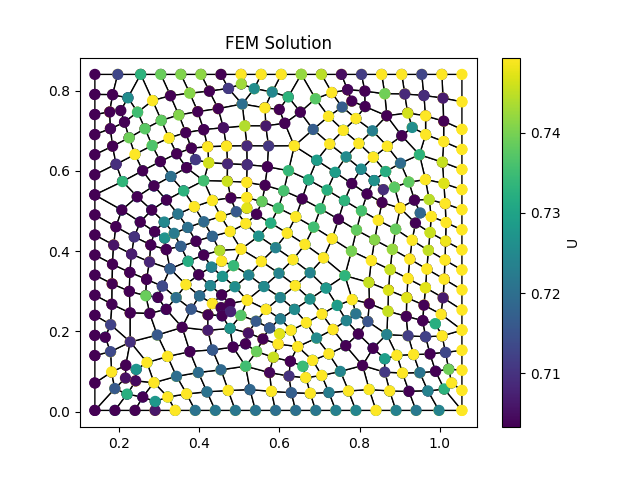

In [11]:
# Read mesh
nodes, xnodes, ynodes, bnodes, nele, nno = readquad(ext="alt", path="files")

# Optionally test mesh
nodes = meshtest(nodes, xnodes, ynodes)

# Solve FEM problem
U, N, Sg, Fg, Mg = FEM_Quadrilateral(nodes, xnodes, ynodes, bnodes, nele, nno)
print("Norm of solution:", N)

# Plot solution
plot_solution(U, nodes, xnodes, ynodes)


In [12]:
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting

def plot_solution_3D(U, nodes, xnodes, ynodes):
    """
    Plot the FEM solution as a 3D surface over the quadrilateral mesh
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_trisurf(xnodes, ynodes, U, cmap='viridis')
    ax.view_init(elev=25, azim=135)
    
    for el_nodes in nodes:
        xx = xnodes[el_nodes]
        yy = ynodes[el_nodes]
        zz = U[el_nodes]

        # Close the patch for plotting
        xx = np.append(xx, xx[0])
        yy = np.append(yy, yy[0])
        zz = np.append(zz, zz[0])

        ax.plot_trisurf(xx, yy, zz, color='lightblue', edgecolor='k', linewidth=0.5, alpha=0.8)
        
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('U')
    ax.set_title('FEM Solution 3D')
    # plt.show()
    # plt.ion()

    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')




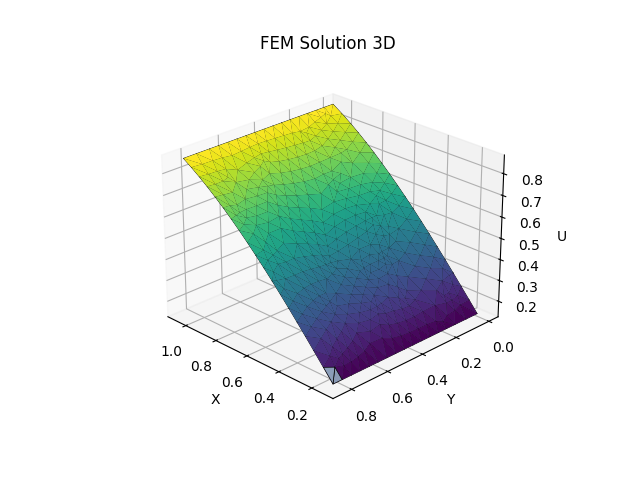

In [13]:
plot_solution_3D(U, nodes, xnodes, ynodes)

# for angle in range(0, 360, 2):
#     ax.view_init(elev=30, azim=angle)
#     plt.draw()
#     plt.pause(0.01)


## Error Norm

The energy norm of the error vector must go to zero as you progressively refine the mesh: 

$$
\| u_h - u \|_{L^2}
=
\sqrt{
(U - U_{\text{exact}})^T
\, M \,
(U - U_{\text{exact}})
}
$$
